In [68]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [69]:
%load_ext autoreload
%autoreload 2
from sysbiojax.measurement.measurment import Series, Reactant, Catalyst, Measurement, Experiment
from sysbiojax.model.model import Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create model

In [70]:
# create data
# Initialize the model
model = Model(name="Menten model with enzyme inactivation")

# Add species
model.add_species("s0, s1, p0")

# Add ODEs
model.add_ode("s0", "- (kcat * p0 * s0) / ( K_m + s0)")
model.add_ode("s1", "(kcat * p0 * s0) / ( K_m + s0)")
model.add_ode("p0", "- k * p0")

# Add parameter values
model.parameters.kcat.value = 20
model.parameters.k.value = 0
model.parameters.K_m.value = 200

model

Eq(x, Matrix([[s0, s1, p0]]))

Eq(theta, Matrix([[K_m, kcat, k]]))

Eq(Derivative(s0, t), -kcat*p0*s0/(K_m + s0))

Eq(Derivative(s1, t), kcat*p0*s0/(K_m + s0))

Eq(Derivative(p0, t), -k*p0)

## Generate data

In [71]:
INIT_ENZYME = 1
INIT_PRODUCT = 0
INIT_SUBSTRATES = [50, 80, 200, 300]

In [72]:
time = jnp.tile(jnp.arange(21), 4).reshape(4, 21)

initial_conditions = [
    dict(s0=value, s1=INIT_PRODUCT, p0=INIT_ENZYME) for value in INIT_SUBSTRATES
]

# K_m, k, kcat
params = jnp.array([100, 0.1, 20])

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1,
    saveat=time,
    parameters=params,
    in_axes=(0, None, 0),
)

In [73]:
catalyst = Catalyst(name="enzyme", symbol="p0", unit="mole / L", init_conc=0)

substrate = lambda init_conc, data: Reactant(
    name="substrate",
    symbol="s0",
    unit="mole / L",
    init_conc=init_conc,
    data=[Series(values=data)],
)

product = lambda init_conc, data: Reactant(
    name="product",
    symbol="s1",
    unit="mole / L",
    init_conc=init_conc,
    data=[Series(values=data)],
)

In [74]:
measurements = list()
for init_condition, data_condition in zip(initial_conditions, data):
    measurements.append(
        Measurement(
            catalysts={"p0": catalyst},
            reactants={
                "s0": substrate(
                    init_conc=init_condition["s0"], data=data_condition[:, 1].tolist()
                ),
                "s1": product(
                    init_conc=init_condition["s1"], data=data_condition[:, 2].tolist()
                ),
            },
            time=time[0].tolist(),
            time_unit="s",
        )
    )

In [75]:
experiment = Experiment(name="Kinetic assay", measurements=measurements)

experiment

Experiment(name='Kinetic assay', measurements=[Measurement(catalysts={'p0': Catalyst(name='enzyme', symbol=p0, init_conc=0.0, unit='mole / L', data=None)}, reactants={'s0': Reactant(name='substrate', symbol=s0, init_conc=50.0, unit='mole / L', data=[Series(values=[50.0, 43.92390823364258, 38.88572692871094, 34.697933197021484, 31.205833435058594, 28.282861709594727, 25.826099395751953, 23.75213623046875, 21.993484497070312, 20.49553680419922, 19.21404457092285, 18.113080978393555, 17.163372039794922, 16.340988159179688, 15.626276016235352, 15.003036499023438, 14.457844734191895, 13.979532241821289, 13.558758735656738, 13.187677383422852, 12.859671592712402])]), 's1': Reactant(name='product', symbol=s1, init_conc=0.0, unit='mole / L', data=[Series(values=[0.0, 6.076091766357422, 11.114272117614746, 15.3020658493042, 18.794174194335938, 21.717145919799805, 24.173908233642578, 26.24787139892578, 28.00652313232422, 29.504470825195312, 30.78596305847168, 31.886926651000977, 32.8366355895996

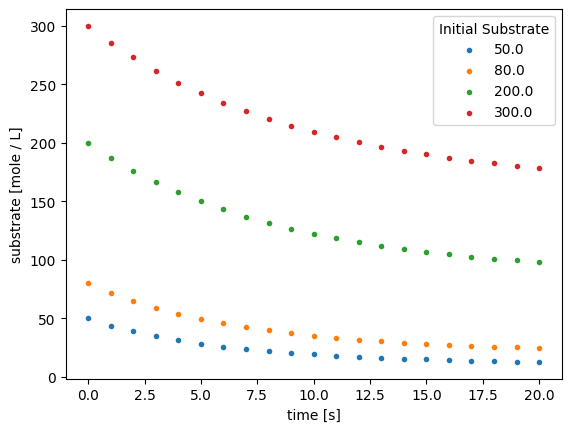

In [81]:
for measurement in experiment.measurements:
    plt.scatter(
        measurement.time,
        measurement.reactants["s0"].data[0].values,
        marker=".",
        label=measurement.reactants["s0"].init_conc,
    )
plt.legend(title="Initial Substrate")
plt.ylabel(f"{measurement.reactants['s0'].name} [{measurement.reactants['s0'].unit}]")
plt.xlabel(f"time [{measurement.time_unit}]")
plt.show()